In [ ]:
# default_exp quaternions
# default_cls_lvl 3

In [ ]:
#hide
%load_ext line_profiler
%matplotlib notebook

# Tensor Quaternion Module
> Pytorch Models for Sequential Data

In [ ]:
#export
from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.callback.schedule import *

## Quaternion Type

In [ ]:
#export
class TensorQuaternions(TensorSequences): pass

In [ ]:
f_paths = '/mnt/Data/Systemidentification/Orientation_Estimation/'
hdf_files = get_hdf_files(f_paths)
tfm_src = CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']
# u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','mag_x','mag_y','mag_z']
y =['opt_a','opt_b','opt_c','opt_d']
dls = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        SequenceBlock.from_hdf(y,TensorQuaternions)),
                get_items=tfm_src,
                splitter=ApplyToDict(FuncSplitter(lambda o: 'experiment2' in str(o)))
               ).dataloaders(hdf_files,shufflish=True,bs=128)

## Basic Operations

In [ ]:
tq1 = tensor([
    [1,0,0,0],
    [0.5,0.5,0.5,0.5],
    ])
tq2 = tensor([
    [0.5,0.5,0.5,0.5],
    [0.5,0.5,0.5,0.5],
    ])
tq1.shape

torch.Size([2, 4])

In [ ]:
#export
_pi = torch.Tensor([3.14159265358979323846])
def rad2deg(t):
    return 180. * t / _pi.to(t.device).type(t.dtype)

In [ ]:
test_eq(float(rad2deg(_pi)),180)

In [ ]:
#export
def multiplyQuat(q1, q2):
    """quat1*quat2"""
    output = torch.zeros_like(q1)
    output[..., 0] = q1[..., 0] * q2[..., 0] - q1[..., 1] * q2[..., 1] - q1[..., 2] * q2[..., 2] - q1[..., 3] * q2[..., 3]
    output[..., 1] = q1[..., 0] * q2[..., 1] + q1[..., 1] * q2[..., 0] + q1[..., 2] * q2[..., 3] - q1[..., 3] * q2[..., 2]
    output[..., 2] = q1[..., 0] * q2[..., 2] - q1[..., 1] * q2[..., 3] + q1[..., 2] * q2[..., 0] + q1[..., 3] * q2[..., 1]
    output[..., 3] = q1[..., 0] * q2[..., 3] + q1[..., 1] * q2[..., 2] - q1[..., 2] * q2[..., 1] + q1[..., 3] * q2[..., 0]
    return output

In [ ]:
test_eq(multiplyQuat(tq1,tq2),tensor([[ 0.5000,  0.5000,  0.5000,  0.5000],
                                    [-0.5000,  0.5000,  0.5000,  0.5000]]))

In [ ]:
#export
def norm_quaternion(q):
    return q / q.norm(dim=-1)[...,None]

In [ ]:
test_eq(norm_quaternion(tq1*5),tq1)
test_eq(norm_quaternion(tq1/_pi),tq1)
test_eq(norm_quaternion(tq1[None,...]),tq1[None,...])

In [ ]:
#export
_conjugate_quaternion = tensor([1,-1,-1,-1])
def conjQuat(q):
    return q * _conjugate_quaternion.to(q.device).type(q.dtype)

In [ ]:
test_eq(conjQuat(tq1),tensor([[ 1.0000, -0.0000, -0.0000, -0.0000],
                             [ 0.5000, -0.5000, -0.5000, -0.5000]]))

In [ ]:
#export
def diffQuat(q1,q2,norm=True):
    if norm:
        nq1 = norm_quaternion(q1)
        nq2 = norm_quaternion(q2)
    else:
        nq1 = q1
        nq2 = q2
    return multiplyQuat(nq1, conjQuat(nq2))

In [ ]:
test_eq(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5,norm=False))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1[None,...],tq2[None,...]))

In [ ]:
#export
def safe_acos(t):
    '''numericaly stable variant of arcuscosine'''
    eps = 3e-8 #minimum value for acos(1) != 0
    return t.clamp(-1.0 + eps, 1.0 - eps).acos()

In [ ]:
test_ne(safe_acos(tensor(1.))*1e6,0)
test_eq(safe_acos(tensor(-0.)),_pi/2)

In [ ]:
#export
def inclinationAngle(q1,q2):
    q = diffQuat(q1,q2)
    return 2*safe_acos((q[..., 3]**2 + q[..., 0]**2).sqrt())

def relativeAngle(q1,q2):
    q = diffQuat(q1,q2)
    return 2*safe_acos((q[..., 0]).abs())

In [ ]:
print('inclination:', rad2deg(inclinationAngle(tq1,tq2)))
print('relative:', rad2deg(relativeAngle(tq1,tq2)))

inclination: tensor([9.0000e+01, 3.9565e-02])
relative: tensor([1.2000e+02, 3.9565e-02])


## Loss Functions

In [ ]:
#export
def ms_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  (inclination**2).mean()

In [ ]:
ms_inclination(tq1,tq2)

tensor(1.2337)

In [ ]:
#export
def rms_inclination_deg(q1,q2):
    return  rad2deg(ms_inclination(q1,q2).sqrt())

In [ ]:
rms_inclination_deg(tq1,tq2)

tensor([63.6396])

In [ ]:
#export
def ms_rel_angle(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  (rel_angle**2).mean()

In [ ]:
ms_rel_angle(tq1,tq2)

tensor(2.1932)

In [ ]:
#export
def rms_rel_angle_deg(q1,q2):
    return  rad2deg(ms_rel_angle(q1,q2).sqrt())

In [ ]:
rms_rel_angle_deg(tq1,tq2)

tensor([84.8528])

## Callbacks

In order to assure that the output of the model are close to unit quaternions the distance will be added to the loss

In [ ]:
#export
from fastai2.callback.hook import *
@delegates()
class QuaternionRegularizer(HookCallback):
    "Callback that adds AR and TAR to the loss, calculated by output of provided layer"
    run_before=TrainEvalCallback
    def __init__(self,reg_unit=0.0,detach=False, **kwargs):
        super().__init__(detach=detach,**kwargs)
        store_attr(self,'reg_unit')
        
    def hook(self, m, i, o): 
        if type(o) is torch.Tensor:
            self.out = o
        else:
            self.out = o[0]
    
    def after_loss(self):
        if not self.training: return
        h = self.out.float()
        
        if self.reg_unit != 0.:  
            l_a = self.reg_unit * ((1-h.norm(dim=-1))**2).mean()
#             import pdb; pdb.set_trace()
            self.learn.loss += l_a 

In [ ]:
n_skip = 2**8

inp,out = get_inp_out_size(dls)
# model = SimpleGRU(inp,out,num_layers=1,hidden_size=100)
# model = TCN(inp,out,hl_depth=8,hl_width=10)

skip = partial(SkipNLoss,n_skip=n_skip)
metrics=rms_inclination_deg
cbs = [QuaternionRegularizer(reg_unit=1,modules=[model])]

lrn = Learner(dls,model,loss_func=ms_inclination,opt_func=ranger,metrics=metrics)

In [ ]:
lrn.fit_one_cycle(5,lr_max=3e-3)

KeyboardInterrupt: 

In [ ]:
lrn.validate(ds_idx=0)

(#2) [0.0662529468536377,13.009443283081055]

## Show Results

In [ ]:
#export
def plot_quaternions_single_figure(n_samples,samples,outs):
    rows=max(1,((n_samples-1) // 3)+1)
    cols=min(3,n_samples)
    fig = plt.figure(figsize=(9,2*cols))
    outer_grid = fig.add_gridspec(rows, cols)
#     import pdb; pdb.set_trace()
    n_targ = 1
    for i in range(n_samples):
        in_signals = samples[i][0]
        targ_signals = samples[i][1]
        out_signals = outs[i][0]
        inner_grid = outer_grid[i].subgridspec(n_targ+1, 1)
        ax = fig.add_subplot(inner_grid[0])
#         import pdb; pdb.set_trace()
        ax.plot(rad2deg(inclinationAngle(out_signals,targ_signals)))
        print(rms_inclination_deg(out_signals,targ_signals))
        ax.label_outer()

        ax = fig.add_subplot(inner_grid[1])
        ax.plot(in_signals)
    plt.tight_layout()
    

In [ ]:
#export
@typedispatch
def show_results(x:TensorSequences, y:TensorQuaternions, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
#     import pdb; pdb.set_trace()
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_quaternions_single_figure(n_samples,samples,outs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_quaternions_single_figure(n_samples,samples,outs)
    return ctxs

<IPython.core.display.Javascript object>


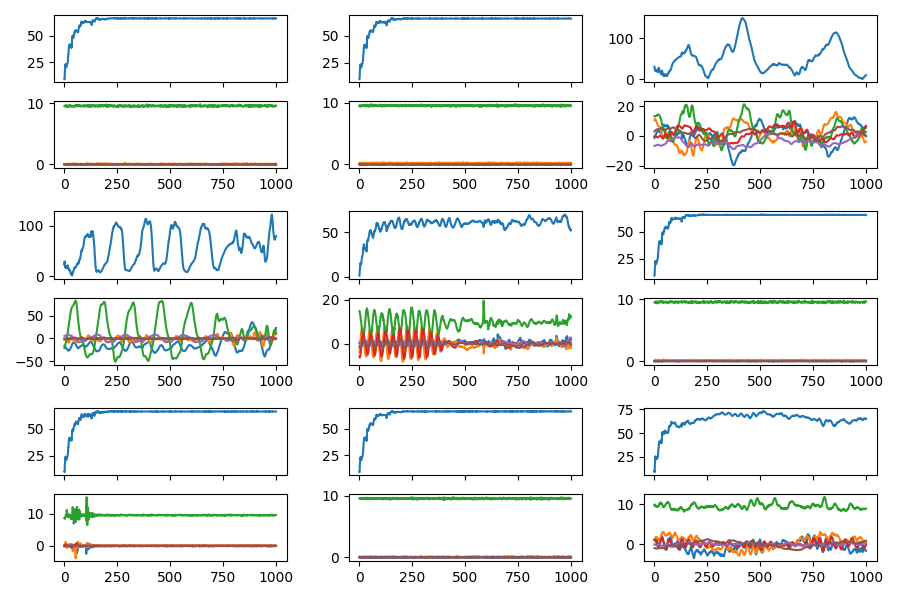

tensor([64.5761])
tensor([64.6013])
tensor([59.6455])
tensor([63.3442])
tensor([59.4769])
tensor([64.2730])
tensor([64.6239])
tensor([64.5789])
tensor([64.1457])


In [ ]:
lrn.show_results(max_n=9,ds_idx=0,shuffle=True)

In [ ]:
x,y =dls.train.one_batch()

In [ ]:
pred = lrn.model(x)
pred.shape,y.shape

(torch.Size([128, 1000, 4]), torch.Size([128, 1000, 4]))

In [ ]:
x.mean(dim=[0,1])

tensor([ 0.0482, -0.0499, -0.0016, -0.0077,  0.0302, -0.0069], device='cuda:0')

In [ ]:
ms_inclination(pred,y)

tensor(1.6481, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_model.ipynb.
Converted 02_learner.ipynb.
Converted 10_performance_test.ipynb.
Converted 11_ProDiag.ipynb.
Converted 11_TensorQuaternions.ipynb.
Converted 93_mdt_benchmark.ipynb.
Converted 96_EEG.ipynb.
Converted 97_Battery.ipynb.
Converted index.ipynb.
